## Import Data

In [ ]:
import pandas as pd
import numpy as np
import time
import missingno as msno
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/junior/14_modeling/sql.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709 entries, 0 to 2708
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         2709 non-null   int64  
 1   delivery_dt      2709 non-null   object 
 2   order_dt         2709 non-null   object 
 3   method_pay       2709 non-null   int64  
 4   category         2541 non-null   object 
 5   amount_category  2541 non-null   float64
 6   adress_deliveri  2709 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 148.3+ KB


In [ ]:
data.shape

(2709, 7)

In [ ]:
data.head()

,order_id,delivery_dt,order_dt,method_pay,category,amount_category,adress_deliveri
0,20118,2027-02-20,31.12.2021,1,Продукты,8.0,Орел
1,64581,2016-02-20,31.12.2020,1,Напитки,14.0,Щелково
2,96710,2021-02-20,31.12.2020,0,Напитки,46.0,Крымск
3,96710,2021-02-20,31.12.2020,0,Часы,84.0,Крымск
4,96710,2001-03-20,31.12.2020,0,Напитки,46.0,Крымск


## Data Understading

In [ ]:
data.delivery_dt.value_counts()

2022-05-20    19
2020-11-20    19
2024-08-20    18
2020-04-20    18
2020-08-20    18
              ..
2003-12-20     1
2025-11-20     1
2026-05-20     1
2014-11-20     1
2001-11-20     1
Name: delivery_dt, Length: 361, dtype: int64

In [ ]:
data.loc[15:15,'delivery_dt']

15    2013-12-20
Name: delivery_dt, dtype: object

In [ ]:
data.sort_values(by='delivery_dt', ascending=False).head()

,order_id,delivery_dt,order_dt,method_pay,category,amount_category,adress_deliveri
1481,56666,2031-12-20,14.11.2022,1,Часы,8.0,Хасавюрт
1480,56666,2031-12-20,14.11.2022,1,Продукты,19.0,Хасавюрт
597,82248,2031-12-20,24.12.2022,0,Часы,21.0,Каменск-Шахтинский
1222,19788,2031-12-20,17.11.2021,1,Одежда,26.0,Юрга
1572,30165,2031-10-20,13.10.2021,1,Напитки,38.0,Екатеринбург


In [ ]:

data.order_dt.value_counts()

28.12.2020    26
22.05.2021    18
28.01.2022    17
22.10.2022    16
02.12.2022    16
              ..
07.04.2020     1
20.05.2021     1
21.02.2021     1
21.07.2020     1
31.12.2021     1
Name: order_dt, Length: 754, dtype: int64

In [ ]:
group_df = data.groupby(['delivery_dt']).agg(order_count=('order_id', 'count')).reset_index()


In [ ]:
group_df['delivery_dt']=pd.to_datetime(group_df['delivery_dt'],format="%Y-%m-%d")

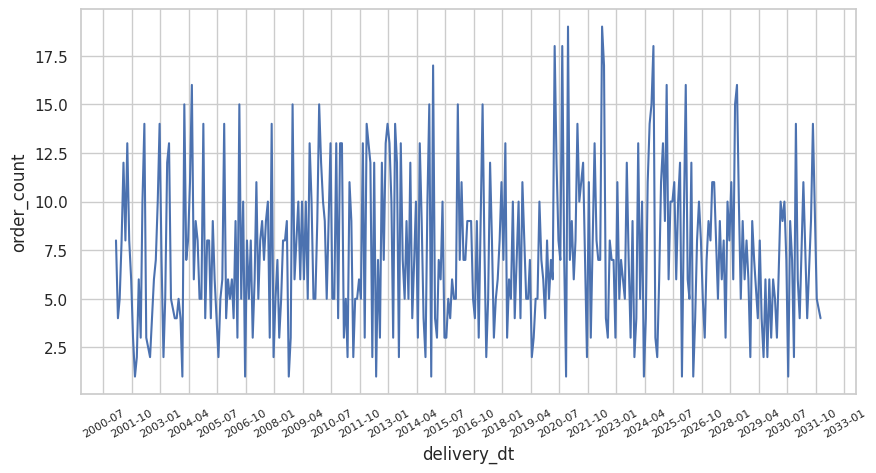

In [ ]:
plt.figure(figsize=(10,5))

ax = sns.lineplot(x='delivery_dt', y='order_count', data = group_df)
plt.xticks(fontsize=8 ,rotation=30)
#ax = sns.lineplot(data=df, x=df['timestamp'], y=df['speed'])

#import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))



plt.show();

## DataPreparation

### Feature Engineering

In [ ]:
df_raw =data.copy()


In [ ]:
df_raw['order_dt'] = pd.to_datetime(df_raw['order_dt'], dayfirst=True).dt.normalize()

In [ ]:
df_raw['delivery_dt'] = pd.to_datetime(df_raw['delivery_dt'])

In [ ]:
df_raw[df_raw['order_dt'].dt.year>2022].shape

(245, 7)

In [ ]:
df_raw.head(10)

,order_id,delivery_dt,order_dt,method_pay,category,amount_category,adress_deliveri
0,20118,2027-02-20,2021-12-31,1,Продукты,8.0,Орел
1,64581,2016-02-20,2020-12-31,1,Напитки,14.0,Щелково
2,96710,2021-02-20,2020-12-31,0,Напитки,46.0,Крымск
3,96710,2021-02-20,2020-12-31,0,Часы,84.0,Крымск
4,96710,2001-03-20,2020-12-31,0,Напитки,46.0,Крымск
5,96710,2001-03-20,2020-12-31,0,Часы,84.0,Крымск
6,47706,2022-01-20,2020-12-31,0,Часы,38.0,Усть-Илимск
7,94569,2014-01-20,2020-12-31,0,NaN,NaN,Когалым
8,64581,2006-02-20,2020-12-31,1,Напитки,14.0,Щелково
9,81099,2020-02-20,2020-12-31,0,Напитки,43.0,Сергиев Посад


In [ ]:
df_raw['difday'] = df_raw['delivery_dt'] - df_raw['order_dt']

In [ ]:
df_raw['diffday'] = df_raw['difday'].dt.days.astype('int16')

In [ ]:
df_raw[(df_raw['diffday'] < 100) & (df_raw['diffday'] > 0)].shape
#выборка очень мала

(114, 9)

Установим важное допущение о том что дата указанная в строке достваки неверна поэтому заменим год на из колонки order data

In [ ]:
for idx in range(len(df_raw)):
  change_year = df_raw.loc[idx,('order_dt')].year
  df_raw.loc[idx,('delivery_dt')] = df_raw.loc[idx,('delivery_dt')].replace((change_year))


In [ ]:

for idx in range(len(df_raw)):
  change_year = df_raw.loc[idx,('order_dt')].year
  if  df_raw.loc[idx,('delivery_dt')] < df_raw.loc[idx,('order_dt')]:
    df_raw.loc[idx,('delivery_dt')] = df_raw.loc[idx,('delivery_dt')].replace((change_year+1))


In [ ]:
df_raw['difday'] = df_raw['delivery_dt'] - df_raw['order_dt']

In [ ]:
df_raw['diffday'] = df_raw['difday'].dt.days.astype('int16')

In [ ]:
df_raw.sort_values(by= 'difday', ascending=True).head()

,order_id,delivery_dt,order_dt,method_pay,category,amount_category,adress_deliveri,difday,diffday
1015,61736,2020-07-20,2020-07-20,1,Часы,34.0,Феодосия,0 days,0
1007,30974,2020-08-20,2020-08-20,1,Напитки,26.0,Электросталь,0 days,0
1008,30974,2020-08-20,2020-08-20,1,Часы,85.0,Электросталь,0 days,0
1060,35916,2020-03-20,2020-03-20,0,Одежда,50.0,Санкт-Петербург,0 days,0
1061,35916,2020-03-20,2020-03-20,0,Часы,26.0,Санкт-Петербург,0 days,0


In [ ]:
df_raw.shape

(2709, 9)

In [ ]:
df_raw.adress_deliveri = df_raw.adress_deliveri.str.lower().replace('-', ' ', regex=True)


In [ ]:
df_raw.adress_deliveri.value_counts()

сарапул        30
севастополь    30
биробиджан     29
архангельск    25
владикавказ    24
               ..
кунгур          1
раменское       1
ноябрьск        1
когалым         1
пушкино         1
Name: adress_deliveri, Length: 305, dtype: int64

In [ ]:
df_raw['weekday_order'] = df_raw['delivery_dt'].dt.dayofweek

In [ ]:
df_raw = df_raw.drop(['delivery_dt','order_dt','order_id','difday'], axis=1, errors='ignore')

### Duplicates

In [ ]:
# вывести дубли
df_raw[df_raw.duplicated()]

,method_pay,category,amount_category,adress_deliveri,diffday,weekday_order
8,1,Напитки,14.0,щелково,51,5
14,0,Напитки,48.0,кострома,50,1
15,0,Часы,13.0,кострома,50,1
16,0,Одежда,1.0,александров,50,1
20,1,Часы,39.0,усолье сибирское,50,0
...,...,...,...,...,...,...
2665,0,Часы,45.0,бийск,50,4
2684,0,Часы,27.0,орск,50,5
2686,0,Часы,27.0,орск,19,2
2690,0,Часы,11.0,ишим,49,1


In [ ]:
## DUBLE
df_raw = df_raw.drop_duplicates()

### GAP

In [ ]:
## пропуски
df_gap = df_raw.copy()

In [ ]:
df_gap.shape

(2421, 6)

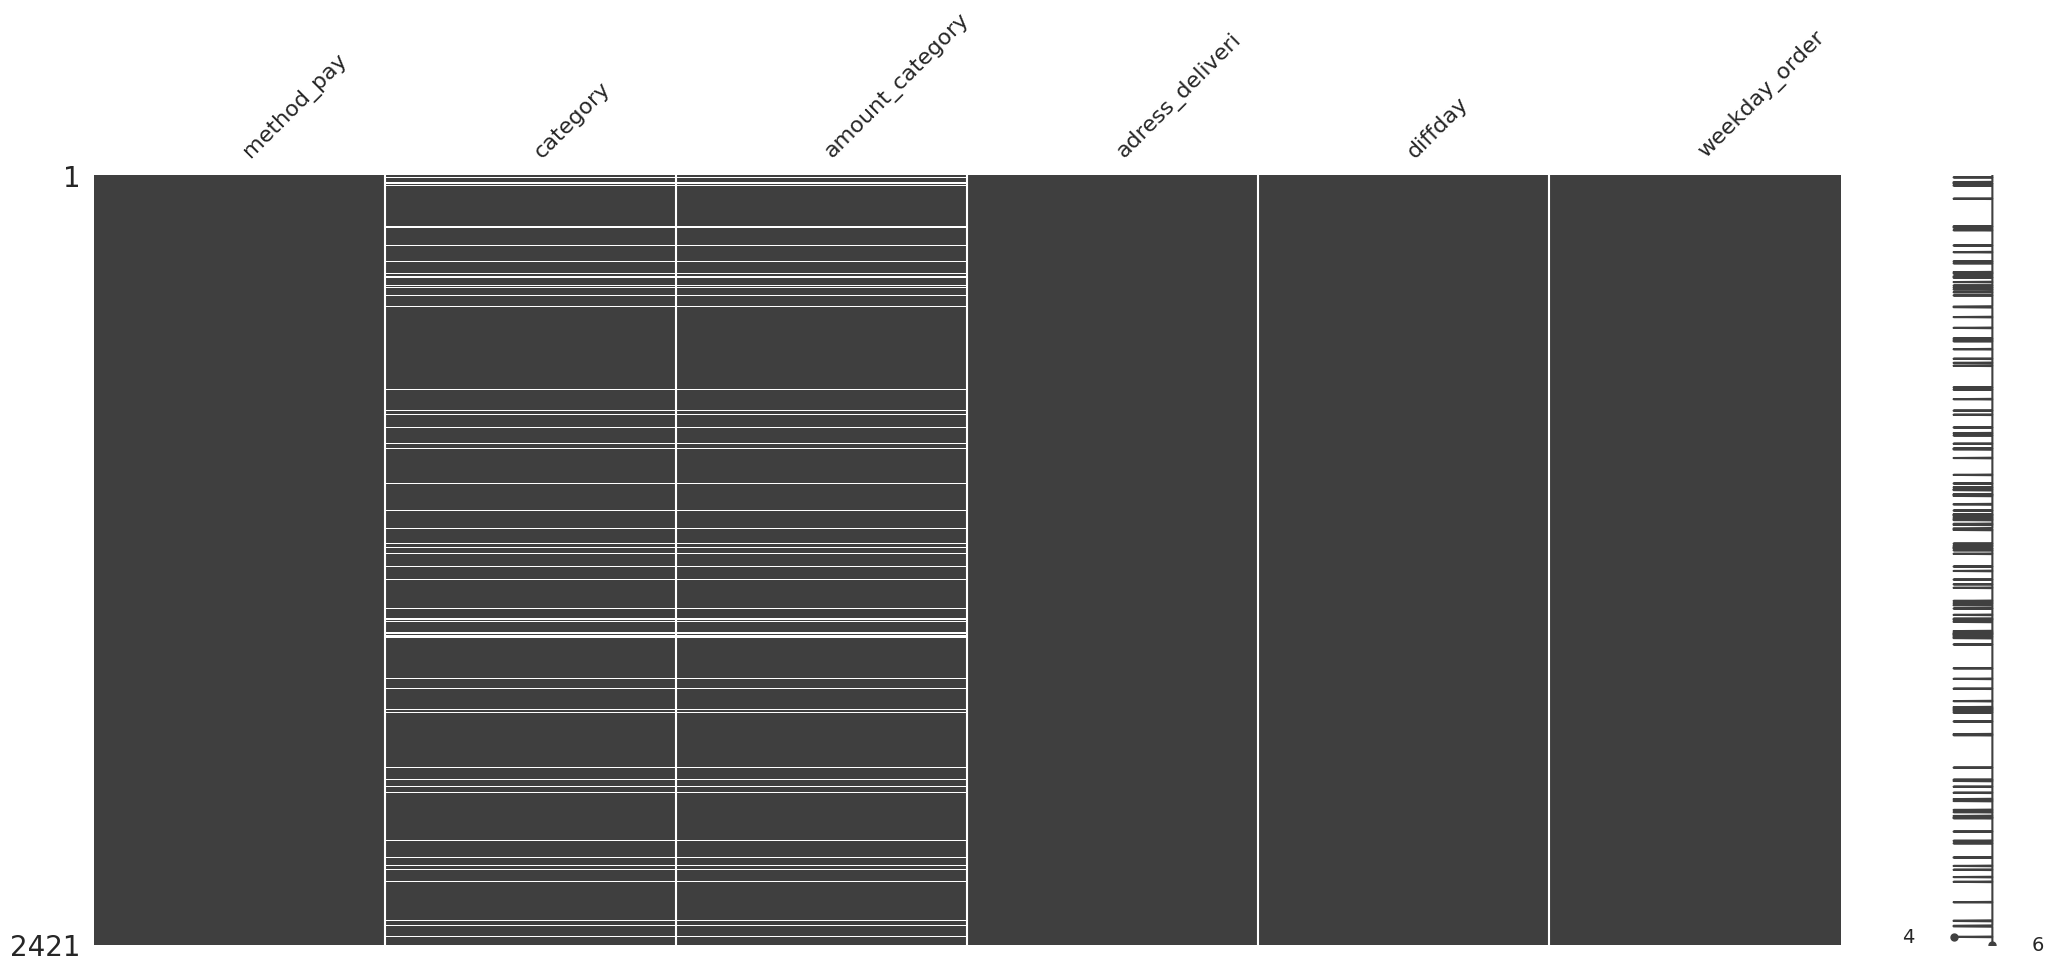

In [ ]:
msno.matrix(df_gap);

In [ ]:
df_gap['category'] = df_gap['category'].fillna('other')

In [ ]:
df_gap[df_gap['amount_category'].isna()]

,method_pay,category,amount_category,adress_deliveri,diffday,weekday_order
7,0,other,NaN,когалым,20,2
29,0,other,NaN,одинцово,20,5
30,0,other,NaN,махачкала,51,0
31,0,other,NaN,зеленодольск,51,6
33,1,other,NaN,ярославль,50,2
...,...,...,...,...,...,...
2617,0,other,NaN,челябинск,77,2
2636,1,other,NaN,ставрополь,18,3
2637,0,other,NaN,балашиха,49,5
2638,0,other,NaN,камышин,19,1


In [ ]:
df_gap['amount_category'] = df_gap['amount_category'].fillna(int(df_gap['amount_category'].mean()))

In [ ]:
missing_values = ((df_gap.isna().sum() / len(df_gap)) * 100).sort_values()
missing_values

method_pay         0.0
category           0.0
amount_category    0.0
adress_deliveri    0.0
diffday            0.0
weekday_order      0.0
dtype: float64

### EMISSION

In [ ]:
##выбосы аномалии

In [ ]:
df_emissions = df_gap.copy()

In [ ]:
df_emissions.head()

,method_pay,category,amount_category,adress_deliveri,diffday,weekday_order
0,1,Продукты,8.0,орел,51,6
1,1,Напитки,14.0,щелково,51,5
2,0,Напитки,46.0,крымск,51,5
3,0,Часы,84.0,крымск,51,5
4,0,Напитки,46.0,крымск,79,5


In [ ]:
df_emissions.shape

(2421, 6)

<Axes: >

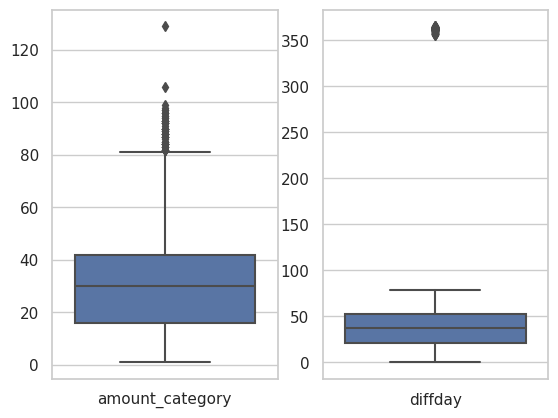

In [ ]:

fig, axes = plt.subplots(1, 2)

sns.boxplot(data=df_emissions[['amount_category']], ax=axes[0])
sns.boxplot(data=df_emissions[['diffday']], ax=axes[1])



In [ ]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [ ]:
boundaries = calculate_outliers(df_emissions['diffday'])
boundaries

(-25.5, 98.5)

In [ ]:
is_outlier = (df_emissions['diffday'] < boundaries[0]) | (df_emissions['diffday'] > boundaries[1])


In [ ]:
is_outlier.sum() / len(df_emissions)

0.03634861627426683

In [ ]:
df_emissions = df_emissions[~is_outlier]

In [ ]:
df_emissions.shape

(2333, 6)

<Axes: >

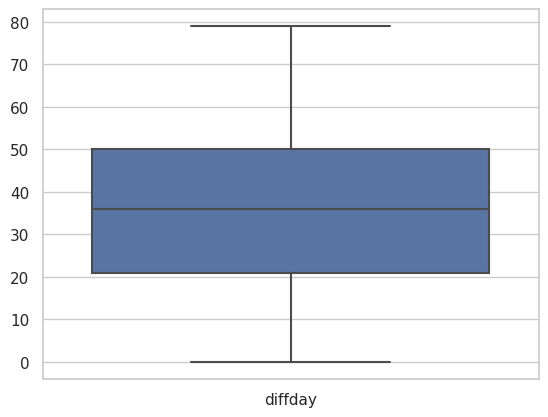

In [ ]:
sns.boxplot(data=df_emissions[['diffday']])


In [ ]:
df_emissions['diffday'].unique()

array([51, 79, 20, 50, 48, 52, 21, 53, 22, 54, 23, 24, 55, 56, 25, 57, 26,
       58, 27, 28, 59, 60, 29, 30, 61, 31,  0, 32,  1, 63, 62, 64, 33,  2,
       34,  3, 65, 35, 66,  4,  5, 36, 37, 68, 67,  6, 38,  7,  8, 39, 70,
       69, 40,  9, 71, 41, 10, 42, 11, 72, 74, 43, 12, 73, 44, 13, 14, 45,
       75, 46, 15, 76, 47, 16, 77, 17, 18, 49, 19], dtype=int16)

In [ ]:
df_emissions[df_emissions['diffday'] == 0]
# нулеые значения тоже выбросы ю удла=им

,method_pay,category,amount_category,adress_deliveri,diffday,weekday_order
992,0,Одежда,53.0,киселевск,0,1
993,0,Продукты,35.0,киселевск,0,1
994,0,Часы,16.0,киселевск,0,1
1005,0,Напитки,6.0,вольск,0,4
1006,0,Продукты,33.0,вольск,0,4
1007,1,Напитки,26.0,электросталь,0,3
1008,1,Часы,85.0,электросталь,0,3
1009,1,Продукты,31.0,электросталь,0,3
1013,1,Продукты,87.0,феодосия,0,0
1015,1,Часы,34.0,феодосия,0,0


In [ ]:
df_emissions[df_emissions['diffday'] == 0].shape

(18, 6)

In [ ]:
df_emissions = df_emissions[~(df_emissions['diffday'] == 0)]

In [ ]:
df_emissions.shape

(2315, 6)

In [ ]:
### amount_category

In [ ]:
boundaries = calculate_outliers(df_emissions['amount_category'])
boundaries

(-23.0, 81.0)

In [ ]:
is_outlier.sum() / len(df_emissions)

0.03801295896328294

In [ ]:
is_outlier = (df_emissions['amount_category'] < boundaries[0]) | (df_emissions['amount_category'] > boundaries[1])

In [ ]:
df_emissions.loc[is_outlier, 'amount_category'] = boundaries[1]

In [ ]:
df_emissions.amount_category.value_counts()

30.0    185
81.0     67
28.0     57
48.0     53
1.0      49
       ... 
67.0      2
76.0      2
72.0      2
80.0      2
75.0      1
Name: amount_category, Length: 80, dtype: int64

In [ ]:
df_emissions.amount_category.unique()

array([ 8., 14., 46., 81., 38., 30., 43.,  1., 13., 48., 50., 39., 26.,
       40., 36.,  3., 21., 47., 33., 24., 34.,  4., 73., 42., 44., 15.,
       29., 10., 20., 35., 67., 41.,  2., 19., 28., 45., 17., 77., 22.,
       64., 18., 27., 23., 49., 69., 25., 12., 53., 55., 52.,  9., 16.,
       78., 57., 11.,  6.,  5., 71., 32., 31., 37., 66., 68.,  7., 54.,
       72., 51., 61., 59., 56., 76., 75., 58., 70., 63., 65., 74., 60.,
       62., 80.])

<Axes: >

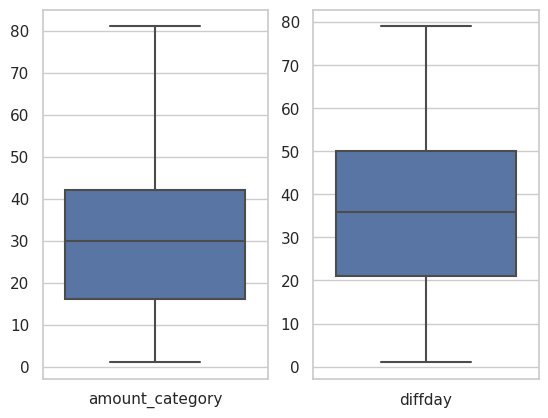

In [ ]:

fig, axes = plt.subplots(1, 2)

sns.boxplot(data=df_emissions[['amount_category']], ax=axes[0])
sns.boxplot(data=df_emissions[['diffday']], ax=axes[1])

In [ ]:
df_emissions.shape

(2315, 6)

In [ ]:
df_emissions.describe()

,method_pay,amount_category,diffday,weekday_order
count,2315.000000,2315.000000,2315.000000,2315.000000
mean,0.528294,30.570626,35.818575,2.971922
std,0.499307,18.693303,18.404414,2.061833
min,0.000000,1.000000,1.000000,0.000000
25%,0.000000,16.000000,21.000000,1.000000
50%,1.000000,30.000000,36.000000,3.000000
75%,1.000000,42.000000,50.000000,5.000000
max,1.000000,81.000000,79.000000,6.000000


## Vizualisation

In [ ]:
df_emissions['category'] = pd.factorize(df_emissions['category'])[0]

<ipython-input-626-9effa8b25ed0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_emissions.corr(), cmap='vlag', center=0, linewidths=.5)


<Axes: >

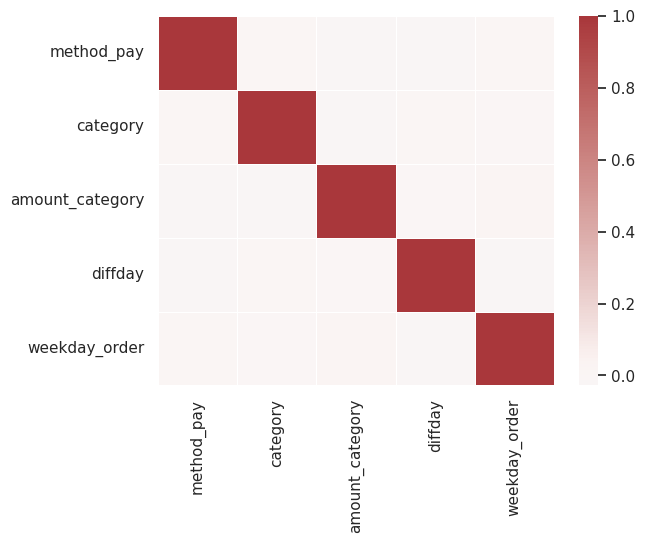

In [ ]:
sns.heatmap(df_emissions.corr(), cmap='vlag', center=0, linewidths=.5)

In [ ]:
# попробуем разбить на группы
df_emissions['diffday'] = pd.cut(df_emissions['diffday'], bins=3, labels=[3, 2, 1])

In [ ]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2315 entries, 0 to 2708
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   method_pay       2315 non-null   int64   
 1   category         2315 non-null   int64   
 2   amount_category  2315 non-null   float64 
 3   adress_deliveri  2315 non-null   object  
 4   diffday          2315 non-null   category
 5   weekday_order    2315 non-null   int64   
dtypes: category(1), float64(1), int64(3), object(1)
memory usage: 110.9+ KB


In [ ]:
df_emissions[df_emissions['diffday']==1]

,method_pay,category,amount_category,adress_deliveri,diffday,weekday_order
4,0,1,46.0,крымск,1,5
5,0,2,81.0,крымск,1,5
219,1,0,43.0,самара,1,5
228,1,1,6.0,самара,1,5
229,1,4,20.0,самара,1,5
...,...,...,...,...,...,...
2588,0,0,22.0,ессентуки,1,4
2589,0,2,16.0,ессентуки,1,4
2617,0,3,30.0,челябинск,1,2
2632,1,2,38.0,новый уренгой,1,0


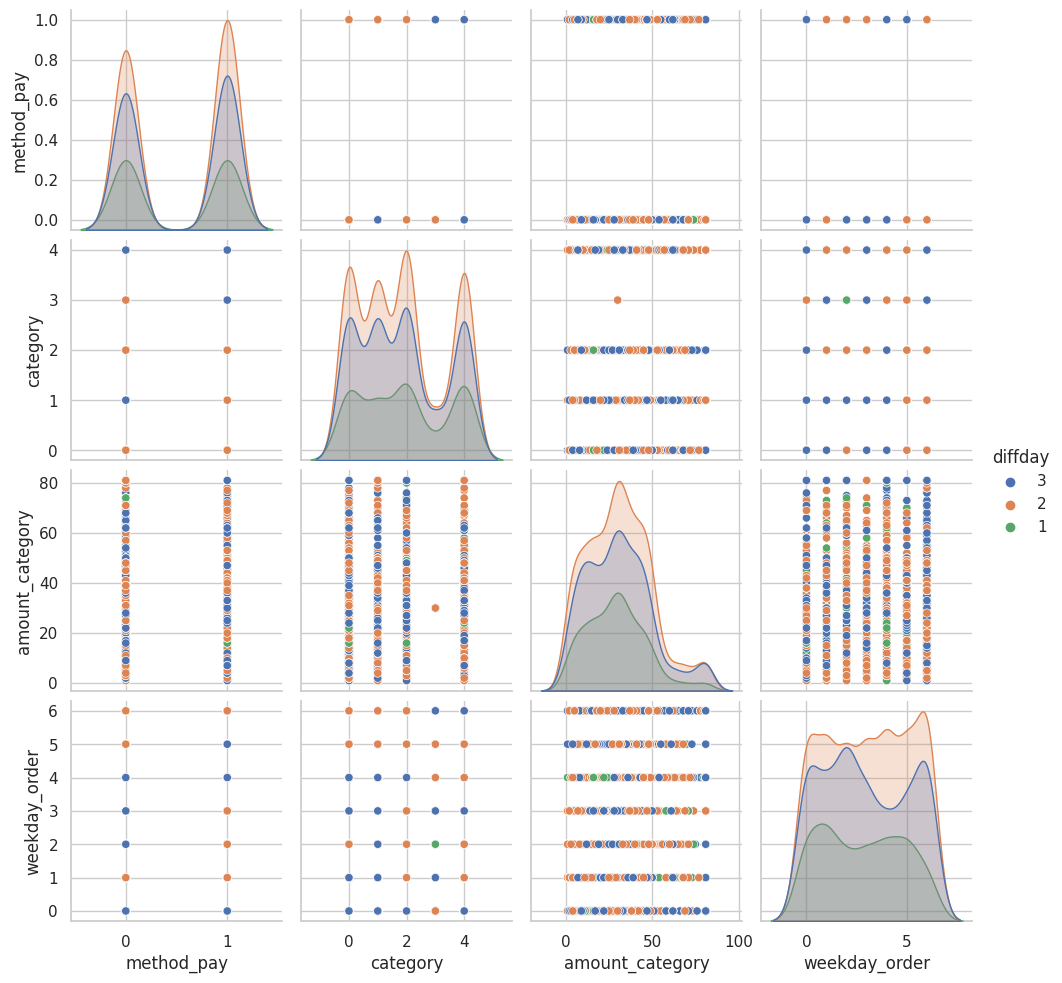

In [ ]:
sns.pairplot(df_emissions, hue='diffday')
plt.show()

##Нормализация

In [ ]:
df_transform = df_emissions.copy()

In [ ]:
df_transform = df_transform.astype({'amount_category' : np.int64})

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
ohe.fit(df_transform[['category']])

OneHotEncoder(sparse_output=False)

In [ ]:
ohe_os = ohe.transform(df_transform[['category']])

In [ ]:
df_transform[ohe.get_feature_names_out()] = ohe_os

In [ ]:
df_transform = df_transform.drop(['category'], axis=1)

In [ ]:
df_transform.shape

(2315, 10)

In [ ]:
ohe.fit(df_transform[['adress_deliveri']])


OneHotEncoder(sparse_output=False)

In [ ]:
ohe_os = ohe.transform(df_transform[['adress_deliveri']])

In [ ]:
df_transform[ohe.get_feature_names_out()] = ohe_os

<ipython-input-641-a1f5190d4d2f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transform[ohe.get_feature_names_out()] = ohe_os
<ipython-input-641-a1f5190d4d2f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transform[ohe.get_feature_names_out()] = ohe_os
<ipython-input-641-a1f5190d4d2f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

In [ ]:
df_transform = df_transform.drop(['adress_deliveri'], axis=1, errors='ignore')

In [ ]:
df_transform.shape

(2315, 312)

In [ ]:
df_transform.head()

,method_pay,amount_category,diffday,weekday_order,category_0,category_1,category_2,category_3,category_4,adress_deliveri_абакан,...,adress_deliveri_щекино,adress_deliveri_щелково,adress_deliveri_электросталь,adress_deliveri_элиста,adress_deliveri_энгельс,adress_deliveri_южно сахалинск,adress_deliveri_юрга,adress_deliveri_якутск,adress_deliveri_ялта,adress_deliveri_ярославль
0,1,8,2,6,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,14,2,5,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,46,2,5,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,81,2,5,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,46,1,5,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ohe.fit(df_transform[['weekday_order']])
ohe_os = ohe.transform(df_transform[['weekday_order']])
df_transform[ohe.get_feature_names_out()] = ohe_os
df_transform = df_transform.drop(['weekday_order'], axis=1)

In [ ]:
df_transform.shape

(2315, 318)

In [ ]:
std_scaler = StandardScaler()

In [ ]:
std_scaler.fit(df_transform[['amount_category']])

StandardScaler()

In [ ]:
std_scaled = std_scaler.transform(df_transform[['amount_category']])

In [ ]:
df_transform['std_amount_category'] = std_scaled

In [ ]:
df_transform = df_transform.drop(['amount_category'], axis=1, errors='ignore')

In [ ]:
df_transform.shape

(2315, 318)

In [ ]:
df_transform.head()

,method_pay,diffday,category_0,category_1,category_2,category_3,category_4,adress_deliveri_абакан,adress_deliveri_александров,adress_deliveri_алексин,...,adress_deliveri_ялта,adress_deliveri_ярославль,weekday_order_0,weekday_order_1,weekday_order_2,weekday_order_3,weekday_order_4,weekday_order_5,weekday_order_6,std_amount_category
0,1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.207679
1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.886639
2,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.825574
3,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.698307
4,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.825574


## Modeling

In [ ]:
df_prepared = df_transform.copy()

In [ ]:
x = df_prepared.drop(['diffday'], axis=1)
y = df_prepared.diffday
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
x_train.shape, x_test.shape

((1620, 317), (695, 317))

###SVC

In [ ]:
#param_grid = [{'C':[1,3,7,10],'degree':[1,3,6],'coef0':[1,5,10,15]}]

In [ ]:
svc = SVC()
"""grid_search = GridSearchCV(svc, param_grid, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train, y_train)"""

"grid_search = GridSearchCV(svc, param_grid, scoring='neg_mean_squared_error', return_train_score=True) \ngrid_search.fit(x_train, y_train)"

In [ ]:
#grid_search.best_params_

In [ ]:
svm_clf = SVC(C=1, degree= 1, coef0= 1)

In [ ]:
svm_clf.fit(x_train, y_train)

SVC(C=1, coef0=1, degree=1)

In [ ]:
predicted_train = svm_clf.predict(x_train)
predicted_test = svm_clf.predict(x_test)

In [ ]:
print(accuracy_score(y_train, predicted_train))
print(accuracy_score(y_test, predicted_test))

0.6518518518518519
0.460431654676259


In [ ]:
svm_clf = SVC(C=1, degree= 3, coef0= 1 , kernel="poly")
svm_clf.fit(x_train, y_train)


SVC(C=1, coef0=1, kernel='poly')

In [ ]:
predicted_train = svm_clf.predict(x_train)
predicted_test = svm_clf.predict(x_test)

In [ ]:
print(accuracy_score(y_train, predicted_train))
print(accuracy_score(y_test, predicted_test))

0.9364197530864198
0.5352517985611511


### TREE

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
predicted_train = clf.predict(x_train)
predicted_test = clf.predict(x_test)

In [ ]:
predicted_train

array([2, 2, 2, ..., 3, 2, 1])

In [ ]:
print(accuracy_score(y_train, predicted_train))
print(accuracy_score(y_test, predicted_test))

0.9925925925925926
0.5453237410071943


In [ ]:
f_imp_list = list(zip(x_train.columns, clf.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)

In [ ]:
f_imp_list

### Линейная регрессия

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)



LinearRegression()

In [ ]:
predicted_train = lr.predict(x_train)
predicted_test = lr.predict(x_test)

In [ ]:
mean_squared_error(predicted_train,y_train, squared = False)

0.598301360554016

In [ ]:
mean_squared_error(predicted_test,y_test, squared = False)

9227201162350.123

In [ ]:
cross_val_predict,
#pl = Pipeline([('sk', sk) , ('model',lr)])
y_predict = cross_val_predict(lr,x_train,y_train)

In [ ]:
mean_squared_error(y_predict,y_train, squared = False)

5452489215036.716

### RandomForest

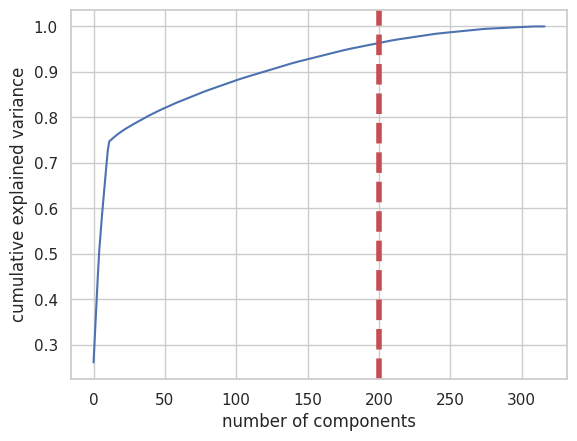

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.261028,0.261028
1,0.326013,0.064985
2,0.390141,0.064128
3,0.451144,0.061003
4,0.506879,0.055735
5,0.548229,0.041350
6,0.587456,0.039227
7,0.623614,0.036158
8,0.659451,0.035837
9,0.694183,0.034732


In [ ]:
# Анализ главных компонент визуализация
pca_test = PCA(n_components=317)
pca_test.fit(x_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=200, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=200)
pca.fit(x_train)
x_train_short = pca.transform(x_train)
x_test_short = pca.transform(x_test)

 #### Обучение базовой RF-модели после применения к данным метода главных компонент

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train_short, y_train)
display(rfc.score(x_train_short, y_train))

0.9925925925925926

#### GidSearch

In [ ]:
## Определим гиперпараметры случайным методом
"""from sklearn.model_selection import RandomizedSearchCV
rfc2 = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc2,
                        param_dist,
                        n_iter = 20,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(x_train_short, y_train)
rs.best_params_"""

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

In [ ]:
# найдем сеткой более точные параметры
n_estimators = [500,700]
max_features = ['sqrt']
max_depth = [12,13,14]
min_samples_split = [10,12,14]
min_samples_leaf = [2,3]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 2, verbose = 1, n_jobs=-1)
gs.fit(x_train_short, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 700}

In [ ]:
rf_clf = RandomForestClassifier(bootstrap = False, max_depth = 13, max_features = 'sqrt',
                                min_samples_leaf = 3, min_samples_split = 10, n_estimators= 700)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=13, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=700)

In [ ]:
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

In [ ]:
print(accuracy_score(y_train, predicted_train_rf))
print(accuracy_score(y_test, predicted_test_rf))

0.5092592592592593
0.45179856115107914


In [ ]:
confusion_matrix(y_train,predicted_train_rf).shape

(3, 3)

In [ ]:
confusion_matrix(y_train,predicted_train_rf)

array([[ 19, 278,   9],
       [  1, 736,   4],
       [  3, 500,  70]])

In [ ]:
precision_score(y_train,predicted_train_rf, average='micro')

0.9925925925925926

In [ ]:
recall_score(y_train,predicted_train_rf, average='micro')

0.9925925925925926

In [ ]:
y_probas = cross_val_predict(rf_clf, x_train, y_train, cv=3, method='predict_proba')

In [ ]:
y_score = y_probas[:, 1]
y_score

array([0.69333333, 0.47      , 0.13      , ..., 0.38      , 0.4       ,
       0.35      ])

### Неройнная сеть

In [ ]:
mlp = MLPClassifier(random_state=12, max_iter=500)


In [ ]:
mlp.fit(x_train, y_train)

MLPClassifier(max_iter=500, random_state=12)

In [ ]:
pred_mlp = mlp.predict(x_test)


In [ ]:
accuracy_score(y_test, pred_mlp)

0.6143884892086331

##Solution